# Chapter 10
# Decision Trees & Decision Rules Explanations

### Data Preparation

In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')

import copy
from sklearn import metrics, tree, model_selection
from tqdm.notebook import trange, tqdm
from imodels import BoostedRulesClassifier, OneRClassifier, GreedyRuleListClassifier,\
                    GreedyTreeClassifier, FIGSClassifier
from imodels import util
from rulefit import RuleFit
from joblib import dump

import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions

/Users/serg/opt/anaconda3/lib/python3.7/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/serg/opt/anaconda3/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/serg/opt/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:35: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  version = LooseVersion(pd.__version__)
/Users/serg/opt/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  pandas_lt_1_0_0 = version < LooseVersion("1.0.0")


In [2]:
ces_df = pd.read_csv('../data/consumer_expenditure_survey.csv.gz',\
                     index_col='CUID')

remove_protected_cols = ['65 or Older', 'Race']
other_remove_cols = ['Fold', 'Date', 'State', 'People', 'Owner', 'Food-Home', 'Food-Total',\
                     'lead-Food-Home', 'lead-Food-Total']
ohe_cols_l = ['Education', 'Sex']

ohe = OneHotEncoder(handle_unknown='ignore')
ohe_np = ohe.fit_transform(ces_df[ohe_cols_l]).toarray()
ces_df[ohe.get_feature_names_out()] = ohe_np

ces_df.drop(remove_protected_cols + other_remove_cols + ohe_cols_l, axis=1, inplace=True)
ces_df.dropna(inplace=True)
ces_df['Income Before Taxes'] = ces_df['Income Before Taxes']/10000

ces_df.to_csv('../data/ces_Ch10.csv', index=False)

In [3]:
ces_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16708 entries, 257896 to 457928
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Data                             16708 non-null  object 
 1   Year                             16708 non-null  int64  
 2   Month                            16708 non-null  int64  
 3   Income Before Taxes              16708 non-null  float64
 4   Number of Bedrooms               16708 non-null  float64
 5   Number of Bathrooms              16708 non-null  float64
 6   Urban                            16708 non-null  int64  
 7   Adults                           16708 non-null  int64  
 8   Children                         16708 non-null  int64  
 9   Working                          16708 non-null  int64  
 10  Retired                          16708 non-null  int64  
 11  Renter                           16708 non-null  float64
 12  Food-Away   

In [4]:
rand = 42
class_l = ['low food away spending','high food away spending']

X = ces_df.drop(['Data', 'Year', 'lead-Food-Away', 'High lead-Food-Away Spending'], axis=1)
y = ces_df[['High lead-Food-Away Spending']]
features_l = X.columns.tolist()

X_train, X_test = X[ces_df.Data == 'Train'], X[ces_df.Data == 'Test']
y_train, y_test = y[ces_df.Data == 'Train'], y[ces_df.Data == 'Test']

In [5]:
prop_high_food_away = y_train['High lead-Food-Away Spending'].mean()
print(f"Percentage High Food Away Spending:\t{prop_high_food_away:.1%}")

Percentage High Food Away Spending:	9.2%


### Model Training & Evaluation

In [6]:
%%time
dt_mdl = tree.DecisionTreeClassifier(random_state=rand, max_depth=3, class_weight={0:3,1:7})
dt_mdl = dt_mdl.fit(X_train, y_train)

CPU times: user 19.2 ms, sys: 6.2 ms, total: 25.4 ms
Wall time: 34.1 ms


In [7]:
dump(dt_mdl, '../models/high_food_away_dt.joblib')

['../models/high_food_away_dt.joblib']

/Users/serg/opt/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:68: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(data.shape, np.bool)
/Users/serg/opt/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:78: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.bool)


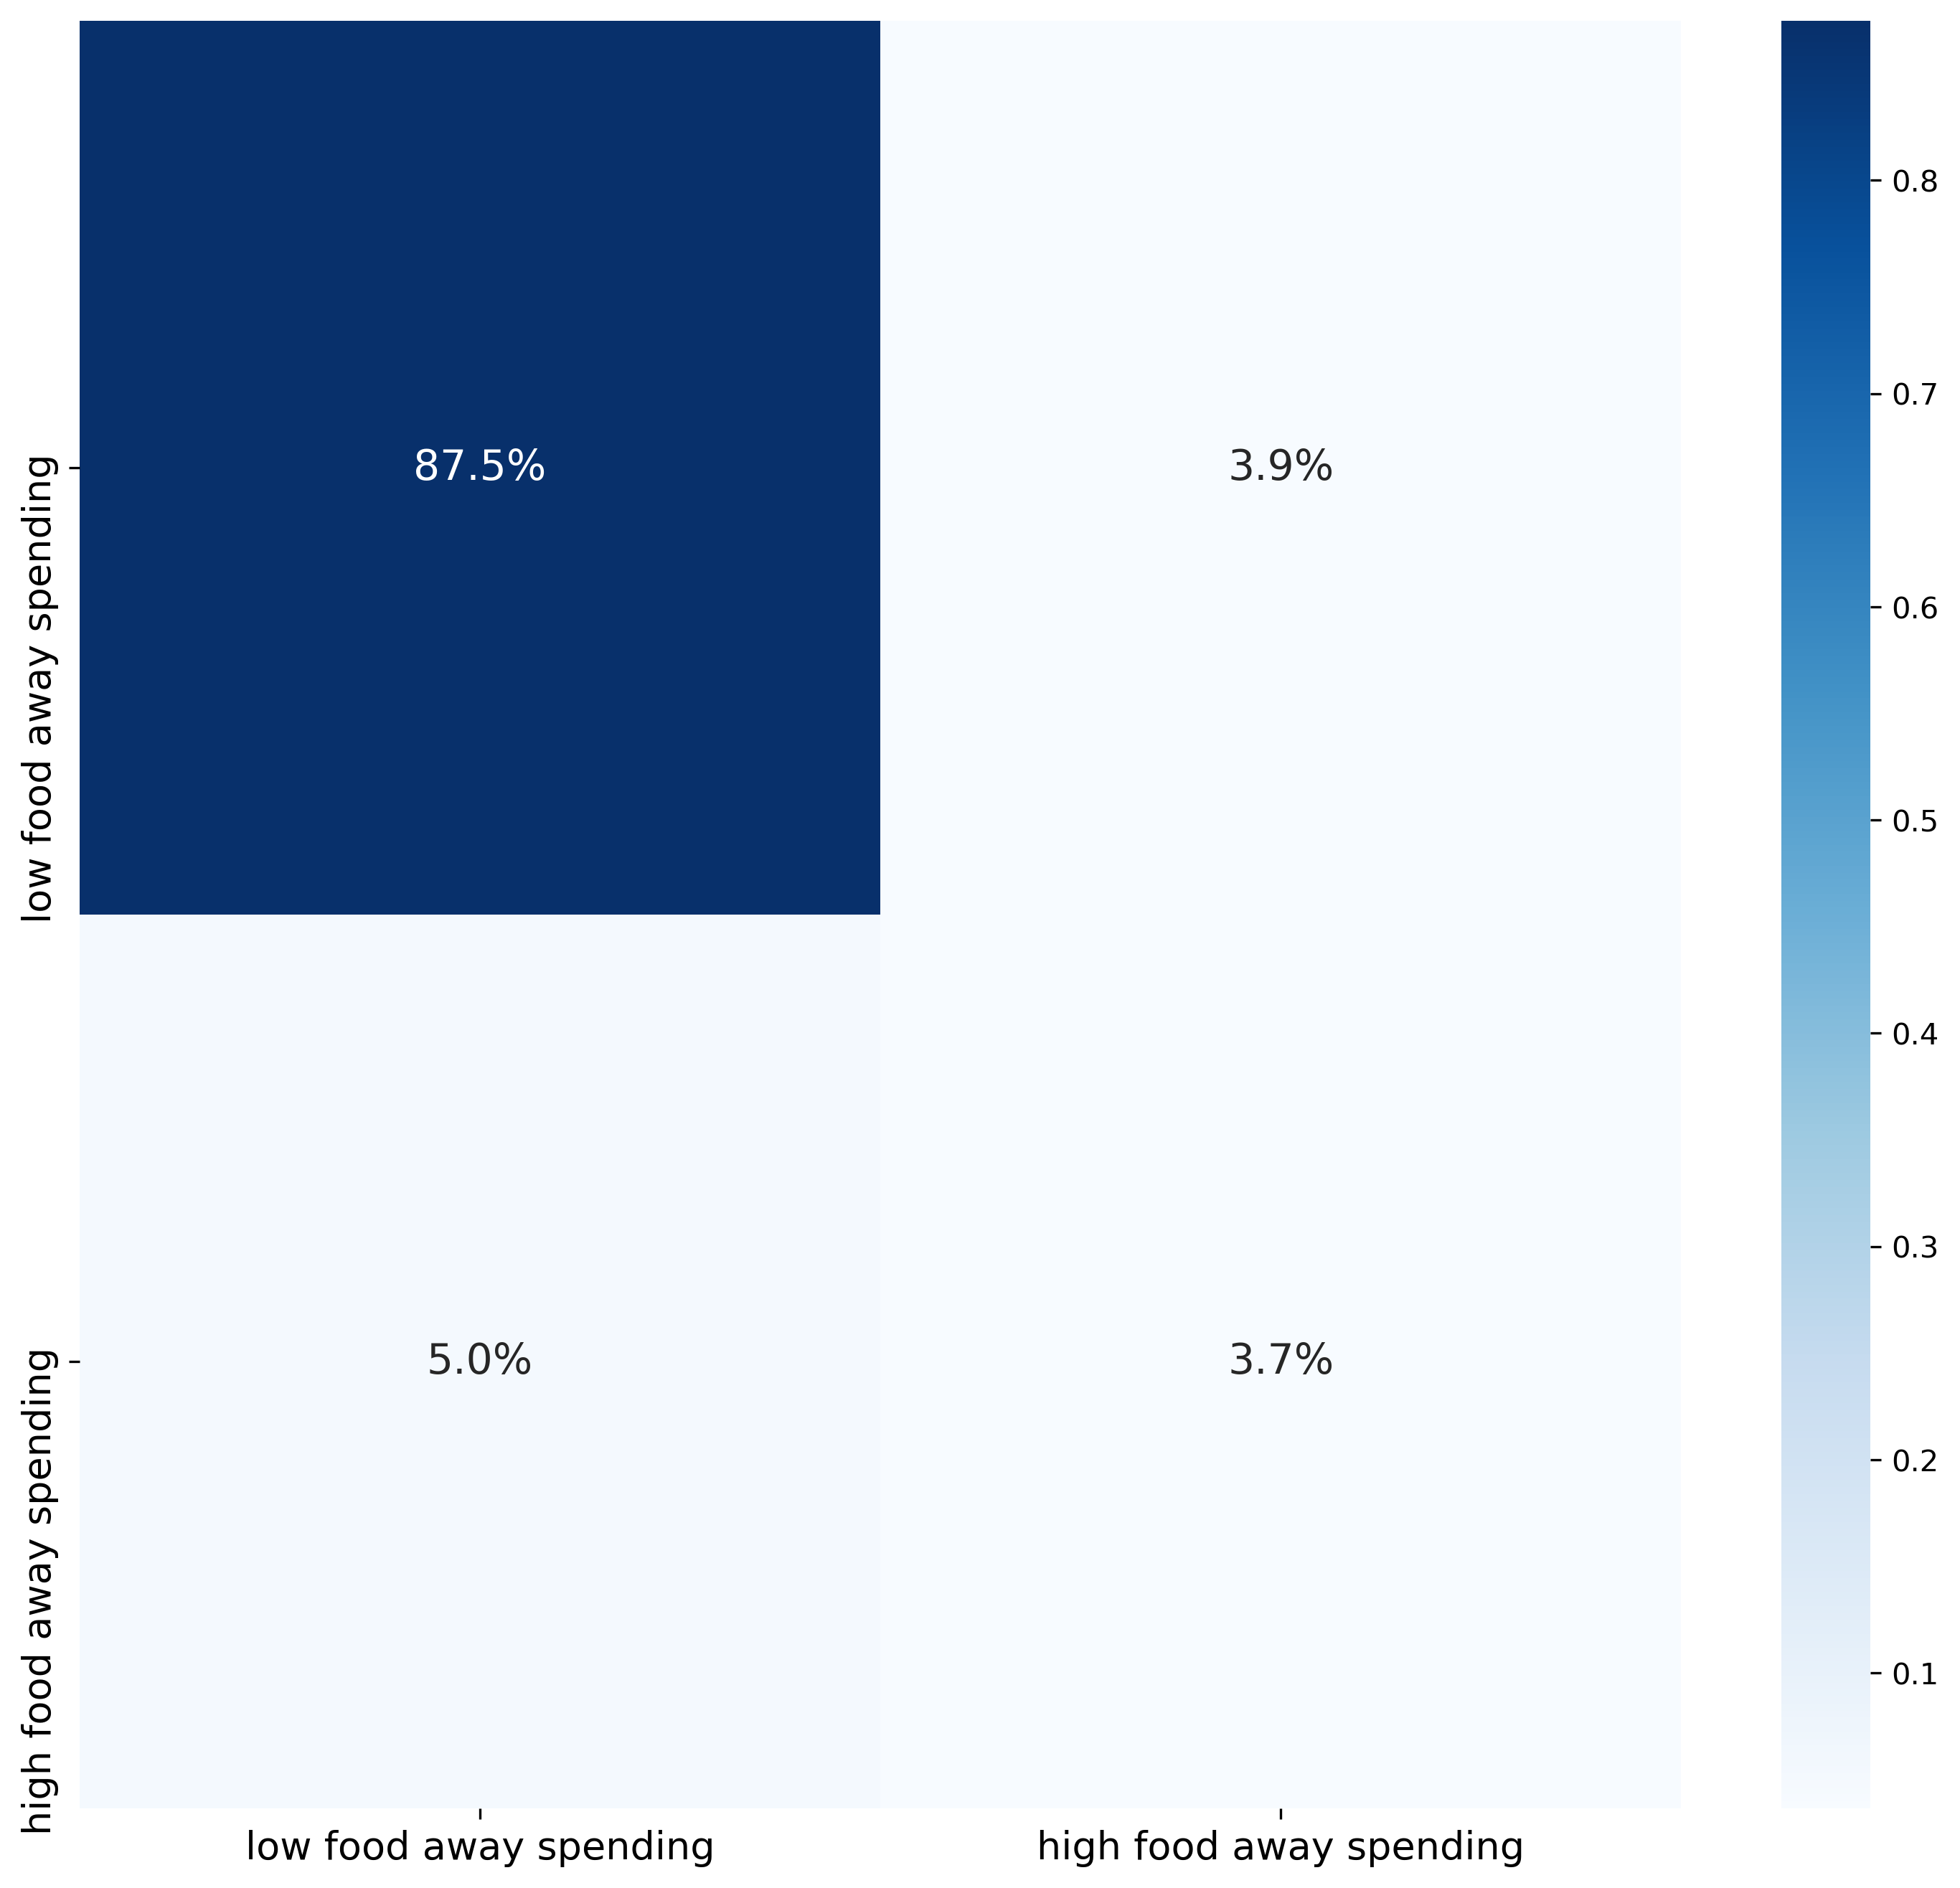

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      2348
           1       0.48      0.42      0.45       222

    accuracy                           0.91      2570
   macro avg       0.72      0.69      0.70      2570
weighted avg       0.91      0.91      0.91      2570



In [8]:
def eval_cls_mdl(mdl, X_test, y_test):
    y_test_pred = mdl.predict(X_test)
    conf_matrix = metrics.confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(12, 11)) 
    res = sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, xticklabels=class_l, yticklabels=class_l,\
                fmt='.1%', cmap='Blues', annot_kws={'size':14})
    res.set_xticklabels(res.get_xmajorticklabels(), fontsize=13)
    res.set_yticklabels(res.get_ymajorticklabels(), fontsize=13)
    plt.show()

    print(metrics.classification_report(y_test, y_test_pred))
    
eval_cls_mdl(dt_mdl, X_test, y_test)

## Understanding what makes Decision Trees ideal for Interpretability

### Revealing the structure of Decision Tree

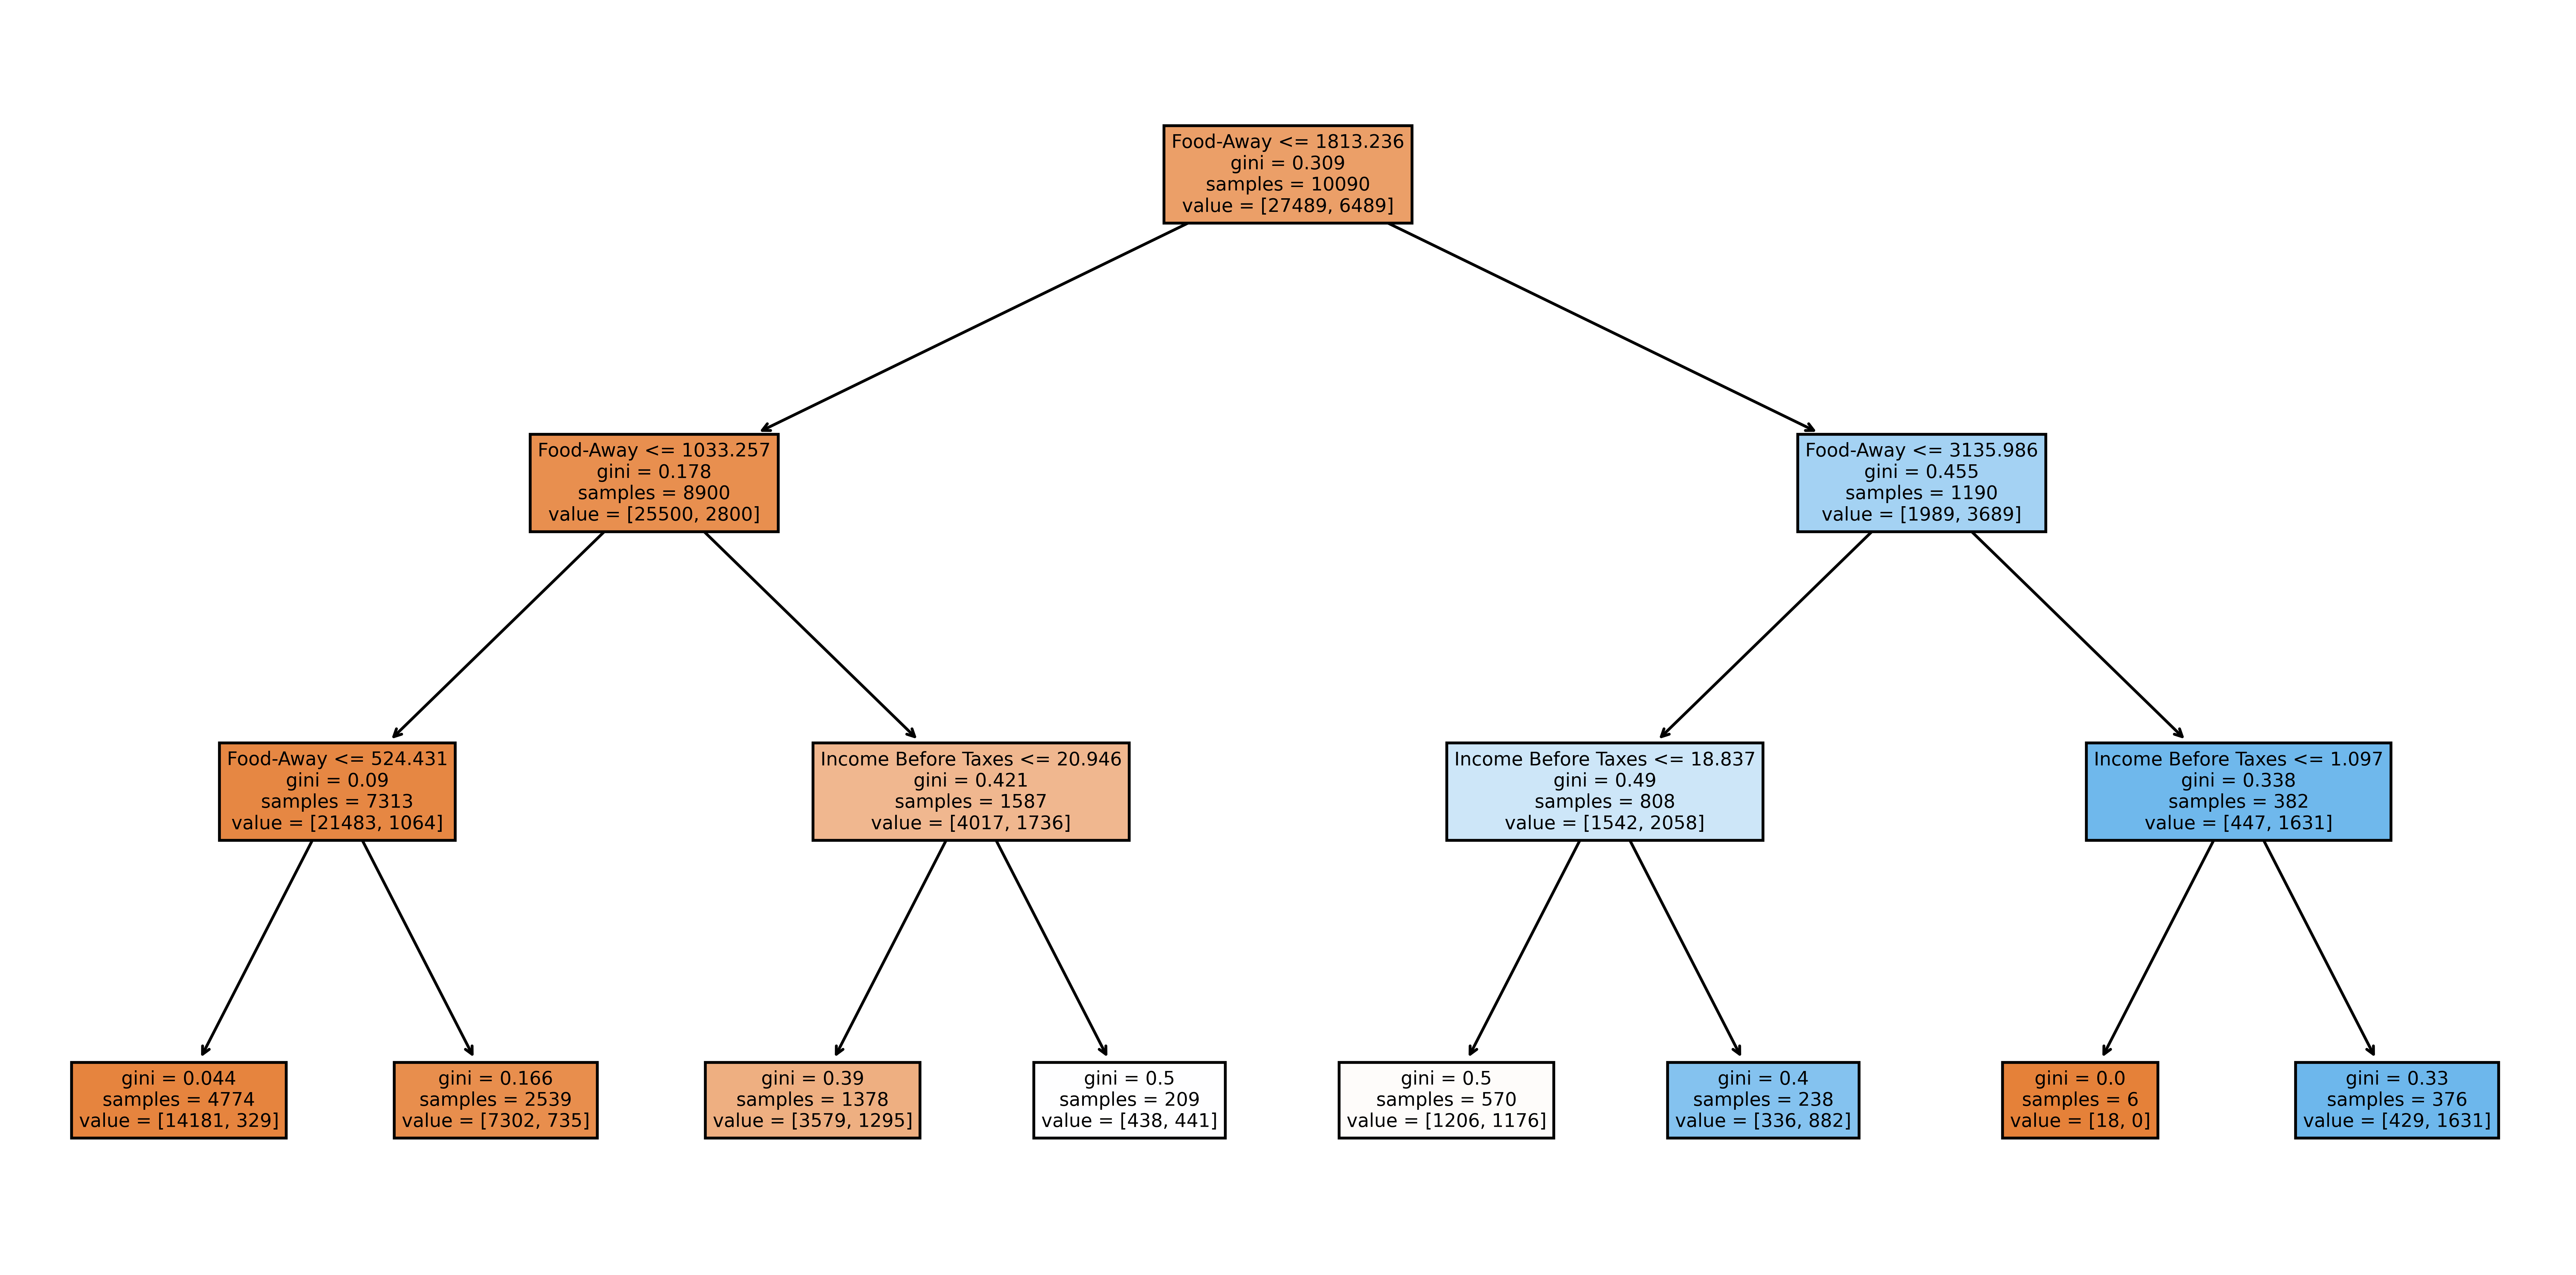

In [9]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (16,8),\
                         dpi=600)
tree.plot_tree(dt_mdl, feature_names=features_l,\
               filled = True, max_depth=3)
fig.show()

In [10]:
dt_mdl_struct = tree.export_text(dt_mdl, feature_names=list(dt_mdl.feature_names_in_))
print(dt_mdl_struct)

|--- Food-Away <= 1813.24
|   |--- Food-Away <= 1033.26
|   |   |--- Food-Away <= 524.43
|   |   |   |--- class: 0
|   |   |--- Food-Away >  524.43
|   |   |   |--- class: 0
|   |--- Food-Away >  1033.26
|   |   |--- Income Before Taxes <= 20.95
|   |   |   |--- class: 0
|   |   |--- Income Before Taxes >  20.95
|   |   |   |--- class: 1
|--- Food-Away >  1813.24
|   |--- Food-Away <= 3135.99
|   |   |--- Income Before Taxes <= 18.84
|   |   |   |--- class: 0
|   |   |--- Income Before Taxes >  18.84
|   |   |   |--- class: 1
|   |--- Food-Away >  3135.99
|   |   |--- Income Before Taxes <= 1.10
|   |   |   |--- class: 0
|   |   |--- Income Before Taxes >  1.10
|   |   |   |--- class: 1



### Extracting Rules from a Decision Tree

In [11]:
np.set_printoptions(suppress=True)

In [12]:
mdl = dt_mdl
mdl_tree = mdl.tree_

print("Node Count:\t%s" % mdl_tree.node_count)
print("Features:\t%s" % mdl_tree.feature)
print("Thresholds:\t%s" % mdl_tree.threshold)
print("Left Children:\t%s" % mdl_tree.children_left)
print("Right Children:\t%s" % mdl_tree.children_right)
print("Values:\t\t%s" % mdl_tree.value)

Node Count:	15
Features:	[10 10 10 -2 -2  1 -2 -2 10  1 -2 -2  1 -2 -2]
Thresholds:	[1813.23638916 1033.25653076  524.43069458   -2.           -2.
   20.9461441    -2.           -2.         3135.98608398   18.83703804
   -2.           -2.            1.09732664   -2.           -2.        ]
Left Children:	[ 1  2  3 -1 -1  6 -1 -1  9 10 -1 -1 13 -1 -1]
Right Children:	[ 8  5  4 -1 -1  7 -1 -1 12 11 -1 -1 14 -1 -1]
Values:		[[[27489.  6489.]]

 [[25500.  2800.]]

 [[21483.  1064.]]

 [[14181.   329.]]

 [[ 7302.   735.]]

 [[ 4017.  1736.]]

 [[ 3579.  1295.]]

 [[  438.   441.]]

 [[ 1989.  3689.]]

 [[ 1542.  2058.]]

 [[ 1206.  1176.]]

 [[  336.   882.]]

 [[  447.  1631.]]

 [[   18.     0.]]

 [[  429.  1631.]]]


In [13]:
def extract_rules_from_dt(tree_, feature_names):

    feature_by_node = [
        feature_names[i] if i != tree._tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    
    def recurse_dt(node, rule='', rule_l=[]):
        if tree_.feature[node] != tree._tree.TREE_UNDEFINED:
            if rule != '':
                rule = rule + ' and '
            name = feature_by_node[node]
            threshold = tree_.threshold[node]
            # formating floats for readability (2 decimals) - change as needed
            rule_left = "{}`{}` <= {:.2f}".format(rule, name, threshold)
            rule_l = recurse_dt(tree_.children_left[node], rule_left, rule_l)
            rule_right = "{}`{}` > {:.2f}".format(rule, name, threshold)
            rule_l = recurse_dt(tree_.children_right[node], rule_right, rule_l)
        else:
            value = tree_.value[node][0]
            prediction = np.argmax(value)
            score = value[1]/value.sum()
            rule_w_pred = (rule, prediction, score)
            rule_l.append(rule_w_pred)
        
        return rule_l

    return recurse_dt(0)

In [14]:
dt_rule_l = extract_rules_from_dt(mdl_tree, mdl.feature_names_in_)
print(dt_rule_l)

[('`Food-Away` <= 1813.24 and `Food-Away` <= 1033.26 and `Food-Away` <= 524.43', 0, 0.022674017918676775), ('`Food-Away` <= 1813.24 and `Food-Away` <= 1033.26 and `Food-Away` > 524.43', 0, 0.09145203434117208), ('`Food-Away` <= 1813.24 and `Food-Away` > 1033.26 and `Income Before Taxes` <= 20.95', 0, 0.2656955272876487), ('`Food-Away` <= 1813.24 and `Food-Away` > 1033.26 and `Income Before Taxes` > 20.95', 1, 0.5017064846416383), ('`Food-Away` > 1813.24 and `Food-Away` <= 3135.99 and `Income Before Taxes` <= 18.84', 0, 0.49370277078085645), ('`Food-Away` > 1813.24 and `Food-Away` <= 3135.99 and `Income Before Taxes` > 18.84', 1, 0.7241379310344828), ('`Food-Away` > 1813.24 and `Food-Away` > 3135.99 and `Income Before Taxes` <= 1.10', 0, 0.0), ('`Food-Away` > 1813.24 and `Food-Away` > 3135.99 and `Income Before Taxes` > 1.10', 1, 0.791747572815534)]


In [15]:
dt_rule_df = pd.DataFrame(dt_rule_l, columns=['rule', 'prediction', 'score'])
dt_rule_df['rule'] = dt_rule_df.rule.str.replace(' and ',' and<br/>')
dt_rule_df['score'] = dt_rule_df['score'] * 100
dt_rule_df.style.\
    format({'score':'{:.1f}%'}).\
    bar(subset=['score'], color='#4EF', width=50)

,rule,prediction,score
0,`Food-Away` <= 1813.24 and`Food-Away` <= 1033.26 and`Food-Away` <= 524.43,0,2.3%
1,`Food-Away` <= 1813.24 and`Food-Away` <= 1033.26 and`Food-Away` > 524.43,0,9.1%
2,`Food-Away` <= 1813.24 and`Food-Away` > 1033.26 and`Income Before Taxes` <= 20.95,0,26.6%
3,`Food-Away` <= 1813.24 and`Food-Away` > 1033.26 and`Income Before Taxes` > 20.95,1,50.2%
4,`Food-Away` > 1813.24 and`Food-Away` <= 3135.99 and`Income Before Taxes` <= 18.84,0,49.4%
5,`Food-Away` > 1813.24 and`Food-Away` <= 3135.99 and`Income Before Taxes` > 18.84,1,72.4%
6,`Food-Away` > 1813.24 and`Food-Away` > 3135.99 and`Income Before Taxes` <= 1.10,0,0.0%
7,`Food-Away` > 1813.24 and`Food-Away` > 3135.99 and`Income Before Taxes` > 1.10,1,79.2%


### Visualizing Decision Boundaries and Regions

In [16]:
X_test_mean = X_test.mean().to_list()
X_test_std = X_test.std().to_list()

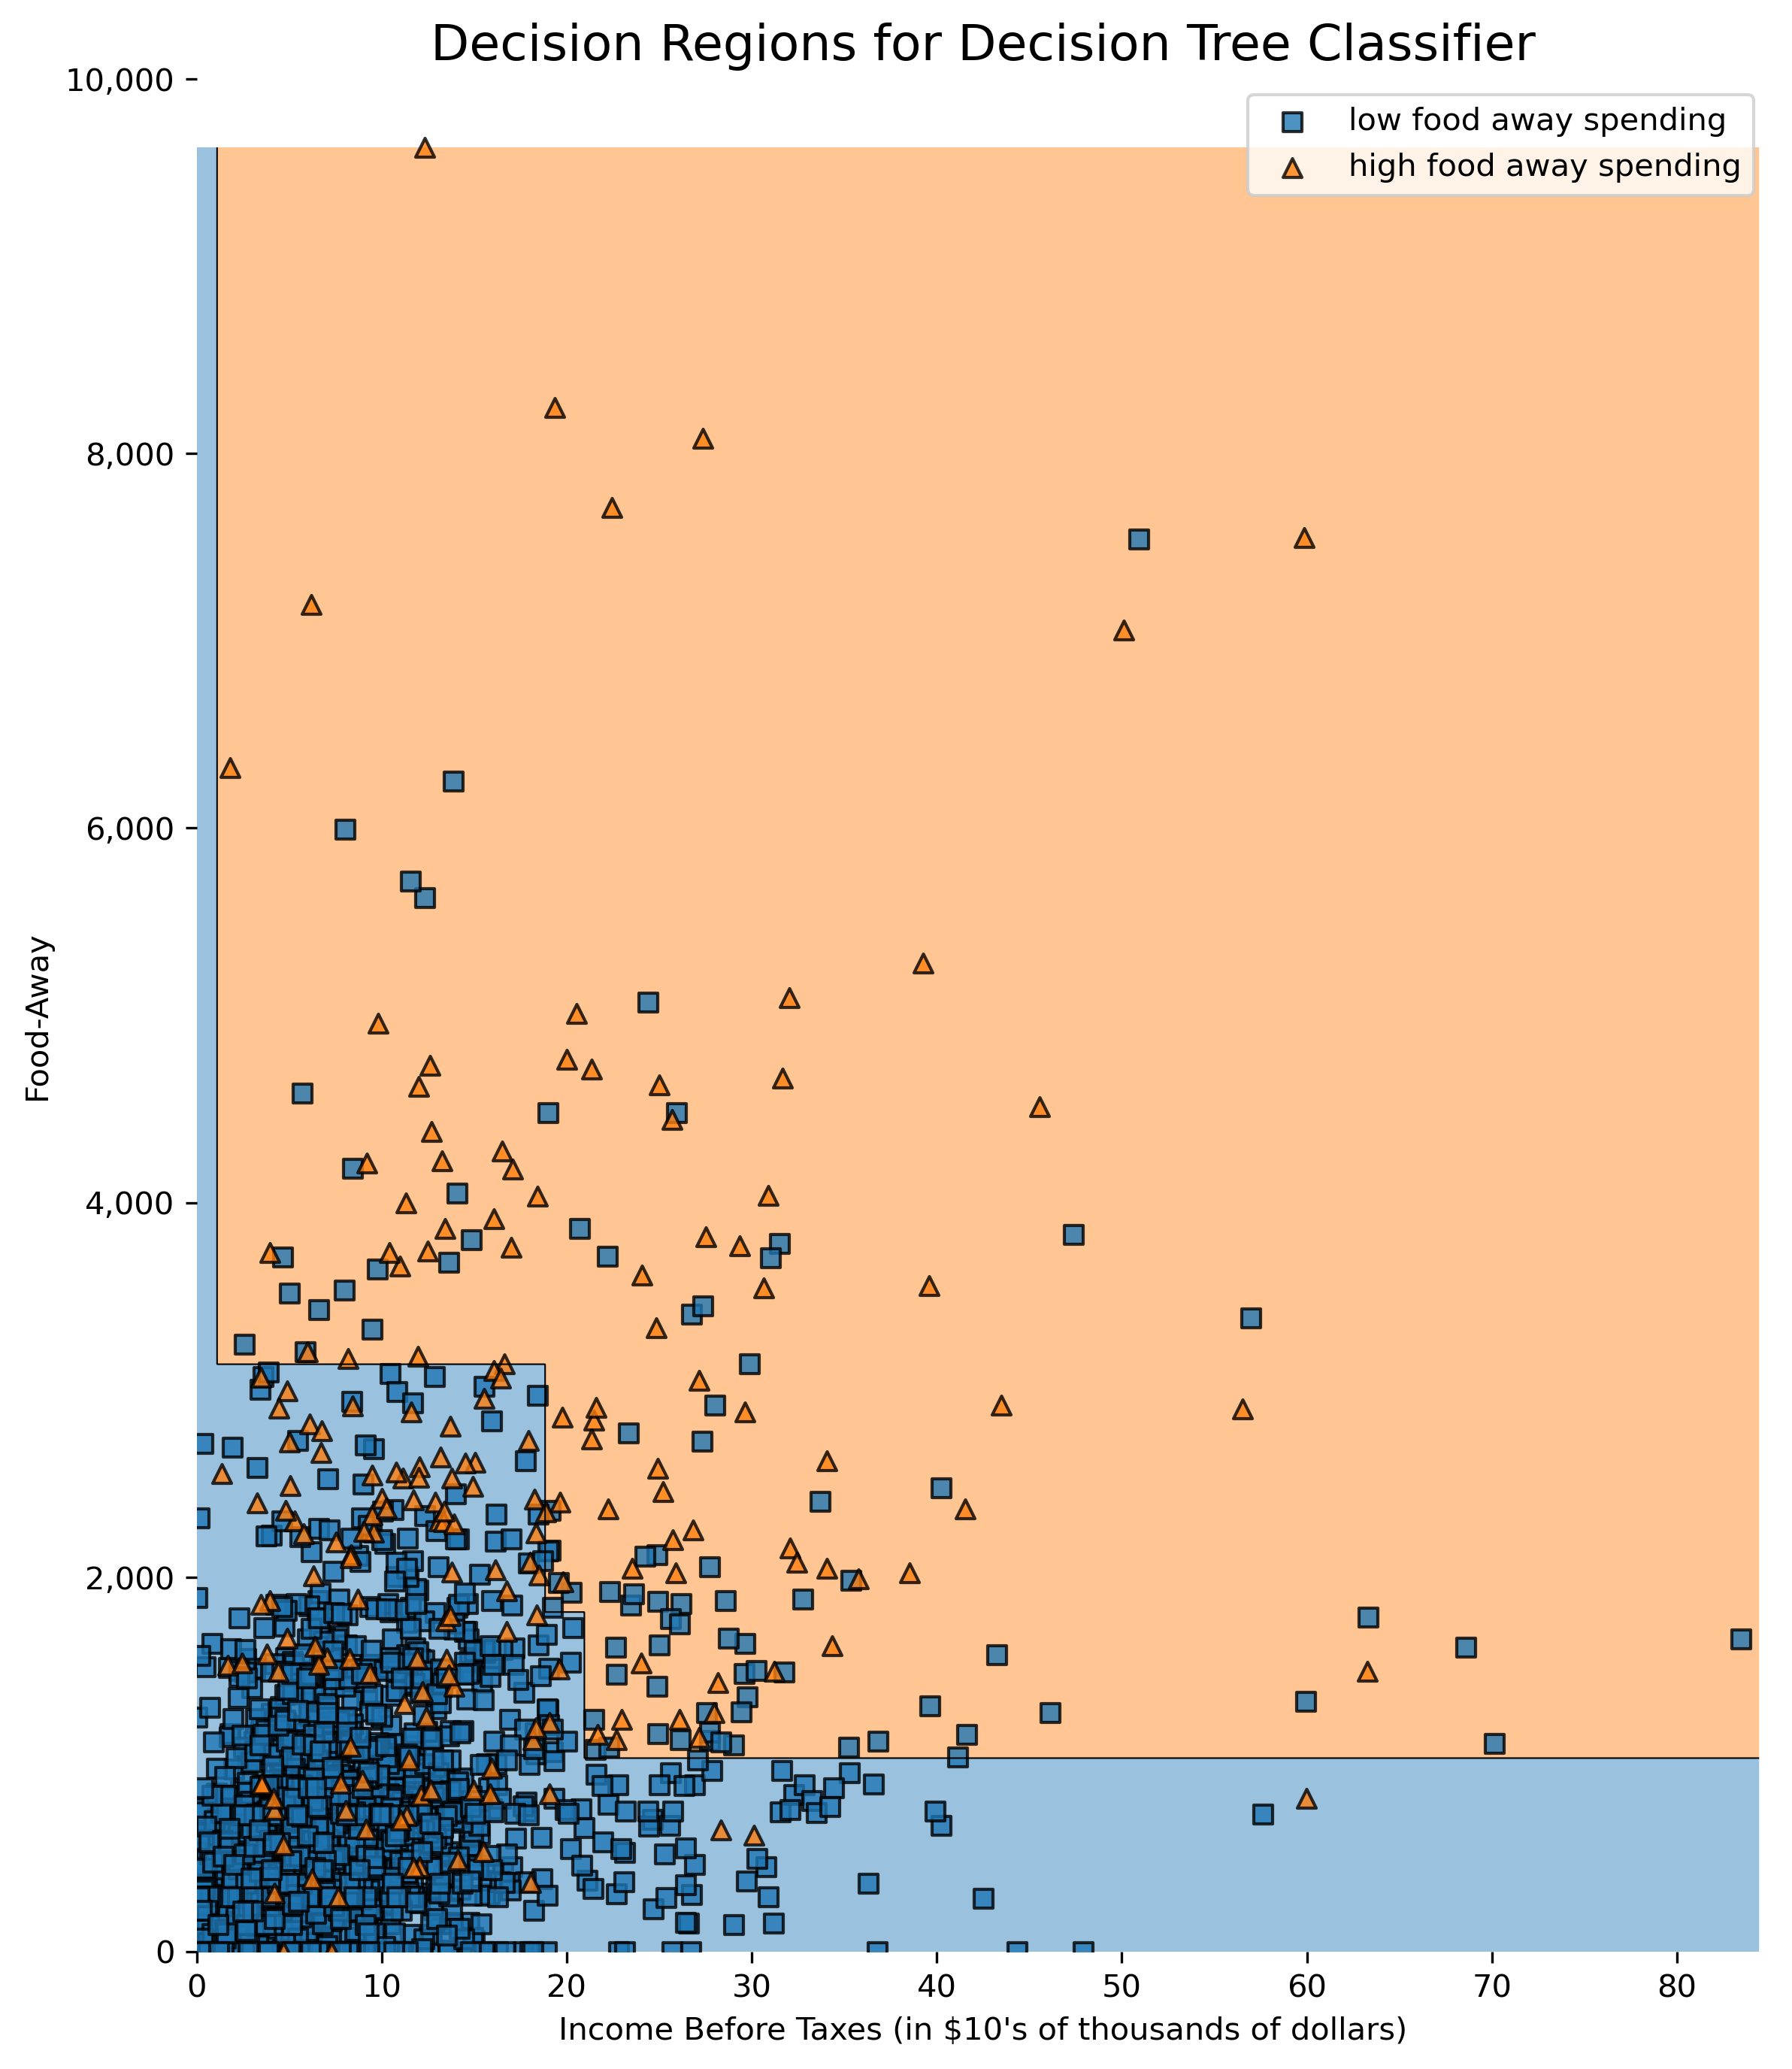

In [17]:
feature_index = [1,10]
filler_values = {i:X_test_mean[i] for i in range(19) if i not in feature_index}
filler_ranges = {i:X_test_std[i]*3 for i in range(19) if i not in feature_index}

plt.figure(figsize=(9, 11))
ax = plot_decision_regions(X_test.values, y_test.values[:,0], clf=mdl, legend=2,\
                    feature_index=feature_index, filler_feature_values=filler_values,\
                    filler_feature_ranges=filler_ranges)
ax.set_xlabel("Income Before Taxes (in $10's of thousands of dollars)")
ax.set_ylabel("Food-Away")
leg=plt.legend()
leg.get_texts()[0].set_text(class_l[0])
leg.get_texts()[1].set_text(class_l[1])
ax.set_xlim(0, 85)
ax.set_ylim(0, 10000)
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
plt.title('Decision Regions for Decision Tree Classifier', fontsize=16)
plt.show()

## Dissecting Rule Set, Rule List, and Rule Tree Models

### Batch Training & Evaluating Models

In [18]:
rule_mdls_dict = {
    #Rule set
    'BoostedRuleSet':BoostedRulesClassifier(n_estimators=10, random_state=rand),
    #Rule list
    'OneR':OneRClassifier(max_depth=3, class_weight={0:3, 1:7}),
    'GreedyRuleList':GreedyRuleListClassifier(max_depth=7, class_weight={0:3, 1:8}),
    #Rule tree
    'GreedyTree':GreedyTreeClassifier(max_depth=5, random_state=rand),
    'FIGS':FIGSClassifier(max_rules=7, random_state=rand),
    #Rule set + Algebraic
    'RuleFit':RuleFit(rfmode='classify', max_rules=28, random_state=rand, n_jobs=-1)
}

In [19]:
%%time
kf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=rand)

cv_scores = {}
for mdl_name in tqdm(rule_mdls_dict.keys()):
    cv_scores[mdl_name] = {'acc_train':[], 'acc_test':[], 'precision':[],\
                           'recall':[], 'f1':[]}
    for train_idxs, test_idxs in kf.split(X.values, y.values[:,0]):
        X_train_cv, X_test_cv = X.iloc[train_idxs].values, X.iloc[test_idxs].values
        y_train_cv, y_test_cv = y.iloc[train_idxs].values[:,0], y.iloc[test_idxs].values[:,0]
        cv_mdl = copy.deepcopy(rule_mdls_dict[mdl_name])
        cv_mdl.fit(X_train_cv, y_train_cv, feature_names=features_l)
        y_train_pred = cv_mdl.predict(X_train_cv)
        y_test_pred = cv_mdl.predict(X_test_cv)
        cv_scores[mdl_name]['acc_train'].append(metrics.accuracy_score(y_train_cv, y_train_pred))
        cv_scores[mdl_name]['acc_test'].append(metrics.accuracy_score(y_test_cv, y_test_pred))
        cv_scores[mdl_name]['precision'].append(metrics.precision_score(y_test_cv, y_test_pred))
        cv_scores[mdl_name]['recall'].append(metrics.recall_score(y_test_cv, y_test_pred))
        cv_scores[mdl_name]['f1'].append(metrics.f1_score(y_test_cv, y_test_pred))
        
    rule_mdls_dict[mdl_name].fit(X_train.values, y_train.values[:,0], feature_names=features_l)

  0%|          | 0/6 [00:00<?, ?it/s]

CPU times: user 8min 35s, sys: 7.99 s, total: 8min 43s
Wall time: 9min 33s


### Comparing Models with Bar Plots

In [20]:
acc_metrics_l = ['acc_train', 'acc_test']
other_metrics_l = ['precision', 'recall', 'f1']

In [21]:
mdl_name_l = rule_mdls_dict.keys()
cv_acc_avg_dict = {met:[np.mean(cv_scores[mdl][met])\
                        for mdl in mdl_name_l]\
                           for met in acc_metrics_l}
cv_acc_std_dict = {met:[np.std(cv_scores[mdl][met])\
                        for mdl in mdl_name_l]
                           for met in acc_metrics_l}
cv_other_avg_dict = {mdl:[np.mean(cv_scores[mdl][met])\
                          for met in other_metrics_l]\
                             for mdl in mdl_name_l}
cv_other_std_dict = {mdl:[np.std(cv_scores[mdl][met])\
                          for met in other_metrics_l]\
                             for mdl in mdl_name_l}

In [22]:
print(cv_acc_avg_dict)

{'acc_train': [0.9026065495412651, 0.9134845662390628, 0.917629293828982, 0.9234648060557162, 0.9211156378252051, 0.9204722466763492], 'acc_test': [0.9017832593652194, 0.9123770982037543, 0.9153101009509367, 0.9178835894677431, 0.9181232895041583, 0.9190806566799413]}


/Users/serg/opt/anaconda3/lib/python3.7/site-packages/seaborn/rcmod.py:412: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/serg/opt/anaconda3/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


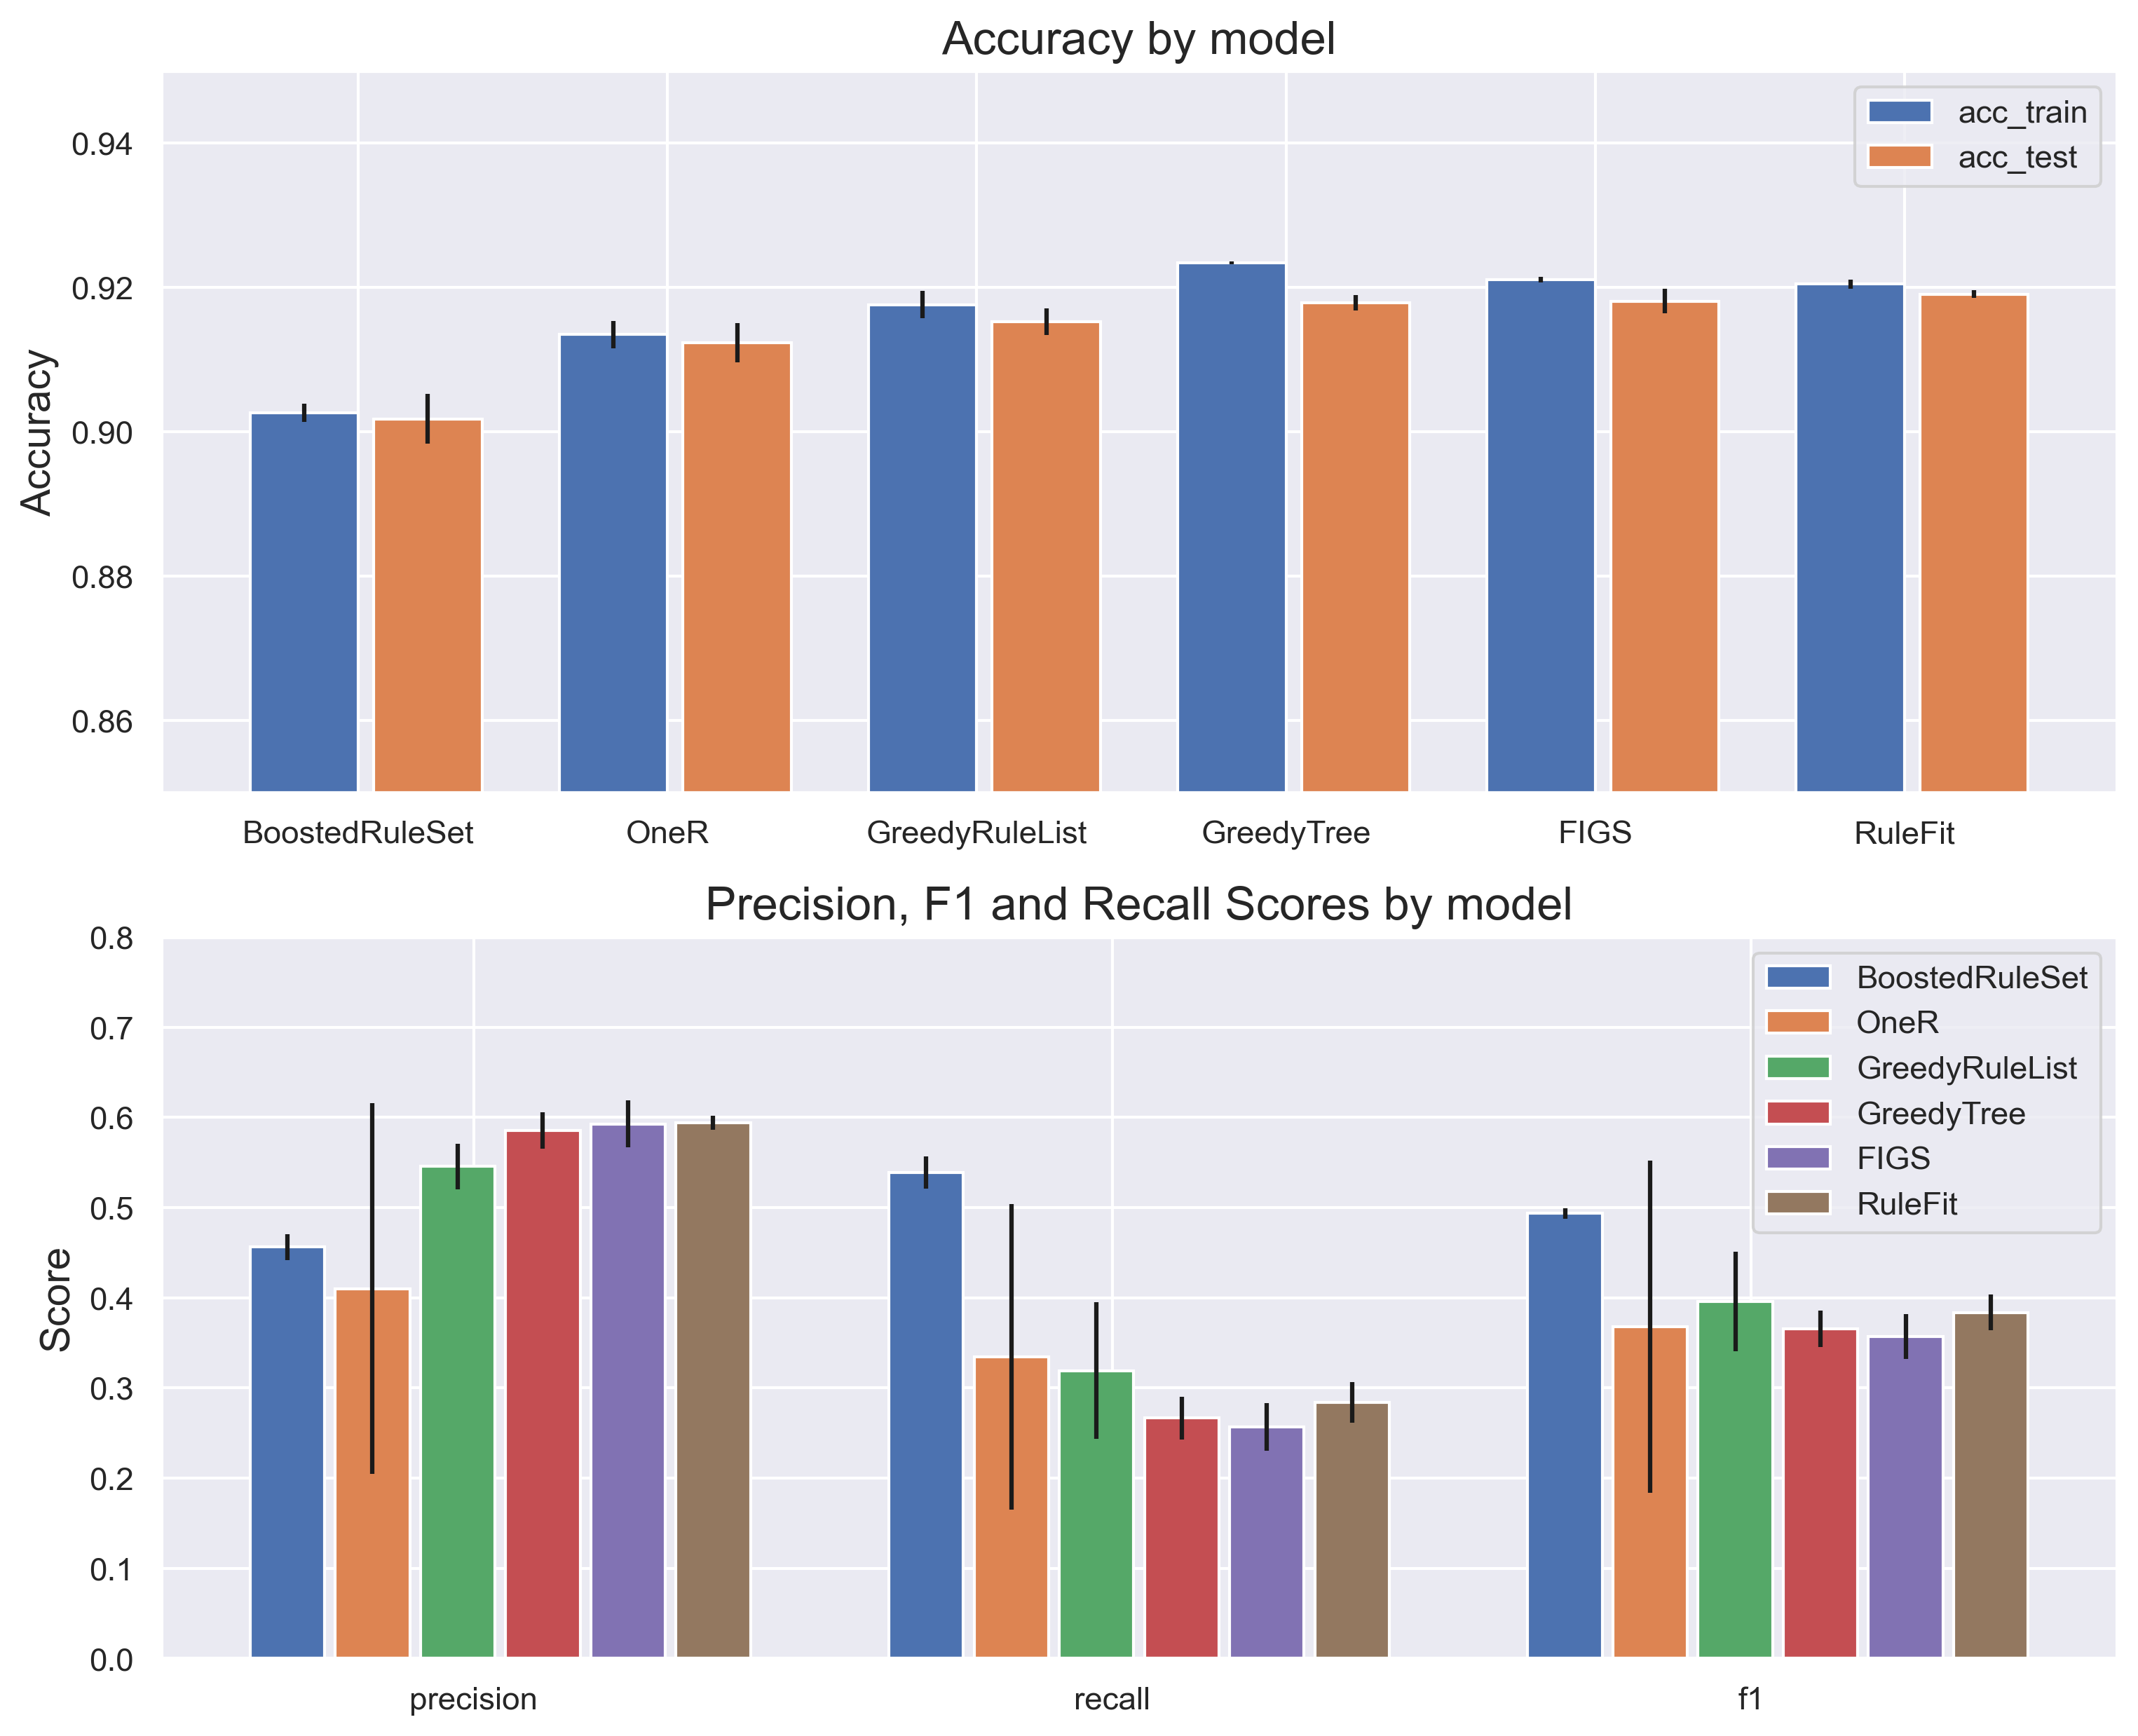

In [23]:
def grouped_bar_plot_w_err(groups_l, avg_dict, std_dict, ylabel, title, ylim, ax):
    ind = np.arange(len(groups_l))
    w = 0.7/len(avg_dict)
    m = w/7
    for i, label in enumerate(avg_dict.keys()):
        ax.bar(ind + (i*(w+m)), avg_dict[label], w, yerr=std_dict[label],\
               label=label, align='center')
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.set_xticks(ind + ((i*w)/2))
    ax.set_xticklabels(tuple(groups_l))
    ax.set_ylim(*ylim)
    ax.legend()

sns.set()
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(12,10))

grouped_bar_plot_w_err(mdl_name_l, cv_acc_avg_dict, cv_acc_std_dict, ylabel='Accuracy',\
                       title='Accuracy by model', ylim=(0.85,0.95), ax=ax0)

grouped_bar_plot_w_err(other_metrics_l, cv_other_avg_dict, cv_other_std_dict, ylabel='Score',\
                       title='Precision, F1 and Recall Scores by model', ylim=(0,0.8),\
                       ax=ax1)

plt.show()

In [24]:
dump(rule_mdls_dict['RuleFit'], '../models/high_food_away_rf.joblib')

['../models/high_food_away_rf.joblib']

### Extracting and Understanding Model Rules

#### Rule set models

In [25]:
mdl = rule_mdls_dict['BoostedRuleSet']
print(mdl)

> ------------------------------
> BoostedRules:
> 	Rule → predicted probability (final prediction is weighted sum of all predictions)
> ------------------------------
  If Food-Away <= 1813.23639 → 0.00 (weight: 1.15)
  If Food-Away > 1813.23639 → 0.28 (weight: 0.72)
  If Food-Away <= 1033.25653 → 0.36 (weight: 0.24)
  If Food-Away > 1033.25653 → 0.07 (weight: 0.20)
  If Income Before Taxes <= 8.85135 → 0.72 (weight: 0.12)
  If Income Before Taxes > 8.85135 → 0.63 (weight: 0.17)
  If Food-Away <= 2348.28723 → 0.09 (weight: 0.13)
  If Food-Away > 2348.28723 → 0.87 (weight: 0.07)
  If Food-Away <= 1019.72537 → 0.02 (weight: 0.07)
  If Food-Away > 1019.72537 → 0.72 (weight: 0.09)



In [26]:
print('# Rules:\t\t%s' % len(mdl.rules_))
print('# Predicted Prob:\t%s' % len(mdl.estimator_mean_prediction_))
print('# Weights:\t\t%s' % len(mdl.estimator_weights_))

# Rules:		20
# Predicted Prob:	10
# Weights:		10


In [27]:
print(mdl.rules_)
print(mdl.estimator_mean_prediction_)
print(mdl.estimator_weights_)

[Food-Away <= 1813.23639, Food-Away > 1813.23639, Food-Away <= 1033.25653, Food-Away > 1033.25653, Income Before Taxes <= 8.85135, Income Before Taxes > 8.85135, Food-Away <= 2348.28723, Food-Away > 2348.28723, Food-Away <= 1019.72537, Food-Away > 1019.72537, Food-Away <= 374.65039, Food-Away > 374.65039, Income Before Taxes <= 20.45209, Income Before Taxes > 20.45209, Income Before Taxes <= 1.80713, Income Before Taxes > 1.80713, Food-Away <= 3760.28735, Food-Away > 3760.28735, Food-Away <= 1019.72537, Food-Away > 1019.72537]
[0.0, 0.2752229930624381, 0.36025768087215065, 0.07165510406342913, 0.7216055500495541, 0.6271555996035679, 0.08592666005946481, 0.8747274529236868, 0.024182358771060456, 0.7216055500495541]
[1.1454876746997427, 0.7210233836871537, 0.23999361089875798, 0.19709614940274633, 0.12273289980170456, 0.1681886330017037, 0.12875331608061935, 0.06958135039141855, 0.07390948615115749, 0.09099796394207157]


#### Rule list models

In [28]:
mdl = rule_mdls_dict['OneR']
print(mdl)

mean 0.092 (10090 pts)
if Food-Away >= 2348.40501049244 then 0.52 (723 pts)
mean 0.059 (9367 pts)
if Food-Away >= 1813.371816934675 then 0.323 (467 pts)
mean 0.045 (8900 pts)
if Food-Away >= 1504.167585118421 then 0.181 (513 pts)



In [29]:
rules_l = mdl.rules_
print('# Rules:\t%s' % len(rules_l))

# Rules:	3


In [30]:
pd.DataFrame(rules_l)

,col,index_col,cutoff,val,flip,val_right,num_pts,num_pts_right
0,Food-Away,10,2348.405010,0.091873,False,0.520055,10090,723
1,Food-Away,10,1813.371817,0.058824,False,0.323340,9367,467
2,Food-Away,10,1504.167585,0.044944,False,0.181287,8900,513


In [31]:
mdl = rule_mdls_dict['GreedyRuleList']
print(mdl.__str__())

rules_l = mdl.rules_
print('# Rules:\t%s' % len(rules_l))

pd.DataFrame(mdl.rules_)

mean 0.092 (10090 pts)
if Food-Away >= 2934.132891954503 then 0.584 (466 pts)
mean 0.068 (9624 pts)
if Food-Away >= 2136.491724855835 then 0.387 (439 pts)
mean 0.053 (9185 pts)
if Adults >= 10.0 then 1.0 (1 pts)
mean 0.053 (9184 pts)
if Food-Away >= 1875.6451505447071 then 0.317 (202 pts)
mean 0.047 (8982 pts)
if Children >= 8.0 then 0.5 (2 pts)
mean 0.047 (8980 pts)
if Sex_Mixed Gender >= 0.0 then 0.047 (8980 pts)

# Rules:	6


,col,index_col,cutoff,val,flip,val_right,num_pts,num_pts_right
0,Food-Away,10,2934.132892,0.091873,False,0.583691,10090,466
1,Food-Away,10,2136.491725,0.068059,False,0.387244,9624,439
2,Adults,5,10.000000,0.052803,False,1.000000,9185,1
3,Food-Away,10,1875.645151,0.052700,False,0.316832,9184,202
4,Children,6,8.000000,0.046760,False,0.500000,8982,2
5,Sex_Mixed Gender,18,0.000000,0.046659,False,0.046659,8980,8980


#### Rule tree models

In [32]:
mdl = rule_mdls_dict['GreedyTree']
print(mdl)

> ------------------------------
> Greedy CART Tree:
> 	Prediction is made by looking at the value in the appropriate leaf of the tree
> ------------------------------
|--- Food-Away <= 1813.24
|   |--- Food-Away <= 1033.26
|   |   |--- Food-Away <= 524.43
|   |   |   |--- Income Before Taxes <= 29.50
|   |   |   |   |--- Income Before Taxes <= 4.73
|   |   |   |   |   |--- weights: [2717.00, 11.00] class: 0
|   |   |   |   |--- Income Before Taxes >  4.73
|   |   |   |   |   |--- weights: [1963.00, 31.00] class: 0
|   |   |   |--- Income Before Taxes >  29.50
|   |   |   |   |--- Food-Away <= 8.63
|   |   |   |   |   |--- weights: [8.00, 5.00] class: 0
|   |   |   |   |--- Food-Away >  8.63
|   |   |   |   |   |--- weights: [39.00, 0.00] class: 0
|   |   |--- Food-Away >  524.43
|   |   |   |--- Income Before Taxes <= 12.25
|   |   |   |   |--- Number of Bedrooms <= 5.50
|   |   |   |   |   |--- weights: [1929.00, 57.00] class: 0
|   |   |   |   |--- Number of Bedrooms >  5.50
|   |  

In [33]:
rules_l = util.convert.tree_to_rules(mdl, feature_names=features_l)
print('# Rules:\t%s' % len(rules_l))

# Rules:	31


In [34]:
print(rules_l)

['Food-Away <= 1813.23639 and Food-Away <= 1033.25653 and Food-Away <= 524.43069 and Income Before Taxes <= 29.50387 and Income Before Taxes <= 4.73425', 'Food-Away <= 1813.23639 and Food-Away <= 1033.25653 and Food-Away <= 524.43069 and Income Before Taxes <= 29.50387 and Income Before Taxes > 4.73425', 'Food-Away <= 1813.23639 and Food-Away <= 1033.25653 and Food-Away <= 524.43069 and Income Before Taxes > 29.50387 and Food-Away <= 8.63141', 'Food-Away <= 1813.23639 and Food-Away <= 1033.25653 and Food-Away <= 524.43069 and Income Before Taxes > 29.50387 and Food-Away > 8.63141', 'Food-Away <= 1813.23639 and Food-Away <= 1033.25653 and Food-Away > 524.43069 and Income Before Taxes <= 12.24967 and Number of Bedrooms <= 5.5', 'Food-Away <= 1813.23639 and Food-Away <= 1033.25653 and Food-Away > 524.43069 and Income Before Taxes <= 12.24967 and Number of Bedrooms > 5.5', 'Food-Away <= 1813.23639 and Food-Away <= 1033.25653 and Food-Away > 524.43069 and Income Before Taxes > 12.24967 and 

In [35]:
mdl = rule_mdls_dict['FIGS']
print(mdl)

> ------------------------------
> FIGS-Fast Interpretable Greedy-Tree Sums:
> 	Predictions are made by summing the "Val" reached by traversing each tree
> ------------------------------
Food-Away <= 1813.236 (Tree #0 root)
	Food-Away <= 1033.257 (split)
		Val: 0.021 (leaf)
		Val: 0.156 (leaf)
	Food-Away <= 3135.986 (split)
		Val: 0.364 (leaf)
		Val: 0.610 (leaf)

	+
Income Before Taxes <= 20.234 (Tree #1 root)
	Food-Away <= 1672.127 (split)
		Val: -0.005 (leaf)
		Number of Bathrooms <= 3.500 (split)
			Income Before Taxes <= 0.870 (split)
				Val: -0.512 (leaf)
				Val: -0.068 (leaf)
			Val: 0.248 (leaf)
	Val: 0.116 (leaf)



In [36]:
print(mdl.trees_)

[X_10 <= 1813.236 (Tree #0 root), X_1 <= 20.234 (Tree #1 root)]


In [37]:
print("Left decision node:\t\t\t%s" % mdl.trees_[0].left)
print("Left decision node feature index:\t%s" % mdl.trees_[0].left.feature)
print("Left decision node threshold:\t\t%.3f" % mdl.trees_[0].left.threshold)
print("Left-Left leaf value:\t\t\t%.3f" % mdl.trees_[0].left.left.value[0][0])
print("Left-Right leaf value:\t\t\t%.3f" % mdl.trees_[0].left.right.value[0][0])

Left decision node:			X_10 <= 1033.257 (split)
Left decision node feature index:	10
Left decision node threshold:		1033.257
Left-Left leaf value:			0.021
Left-Right leaf value:			0.156


#### Evaluating individual rules

In [38]:
rule1 = "`Food-Away` > 3135.986 and `Income Before Taxes` <= 20.234 and `Food-Away` > 1672.127 and `Number of Bathrooms` > 3.5"
rule2 = "`Food-Away` > 3135.986 and `Income Before Taxes` > 20.234"

In [39]:
rule = rule1
rule_train_pred_df = y_train.loc[X_train.query(rule).index]
train_count = len(rule_train_pred_df)
train_sum = rule_train_pred_df.iloc[:,0].sum()
train_precision = train_sum / train_count

rule_test_pred_df = y_test.loc[X_test.query(rule).index]
test_count = len(rule_test_pred_df)
test_sum = rule_test_pred_df.iloc[:,0].sum()
test_precision = test_sum / test_count

print(f"Train support:\t\t{train_count}")
print(f"Train precision:\t{train_precision:.1%}")
print(f"Test precision:\t\t{test_precision:.1%}")

Train support:		12
Train precision:	91.7%
Test precision:		0.0%


In [40]:
rule_train_pred_df

,High lead-Food-Away Spending
CUID,
264389,1
264722,1
268204,1
269865,1
279042,0
316575,1
329718,1
365848,1
366296,1


In [41]:
rule_test_pred_df

,High lead-Food-Away Spending
CUID,
316512,0
382450,0


In [42]:
rule = rule2
rule_train_pred_df = y_train.loc[X_train.query(rule).index]
train_count = len(rule_train_pred_df)
train_sum = rule_train_pred_df.iloc[:,0].sum()
train_precision = train_sum / train_count

rule_test_pred_df = y_test.loc[X_test.query(rule).index]
test_count = len(rule_test_pred_df)
test_sum = rule_test_pred_df.iloc[:,0].sum()
test_precision = test_sum / test_count

print(f"Train support:\t\t{train_count}")
print(f"Train precision:\t{train_precision:.1%}")
print(f"Test precision:\t\t{test_precision:.1%}")

Train support:		143
Train precision:	72.7%
Test precision:		67.6%


In [43]:
y_true_ = rule_test_pred_df['High lead-Food-Away Spending'].to_list()
y_pred_ = [1] * len(rule_test_pred_df)
test_precision = metrics.precision_score(y_true_, y_pred_)

print(f"Test precision:\t\t{test_precision:.1%}")

test_recall = (rule_test_pred_df.count() / y_test.sum()).iloc[0]

print(f"Test recall:\t\t{test_recall:.1%}")

Test precision:		67.6%
Test recall:		16.7%


In [44]:
ces_df.loc[rule_train_pred_df.index].\
    groupby('Year')['High lead-Food-Away Spending'].agg(['mean','count']).\
    rename(columns={'mean':'train_precision', 'count':'support'})

,train_precision,support
Year,,
2013,0.550000,20
2014,0.700000,30
2015,0.680000,25
2016,0.925926,27
2017,0.687500,16
2018,0.760000,25


#### RuleFit

In [45]:
mdl = rule_mdls_dict['RuleFit']
print('# Rules:\t%s' % len(mdl.rule_ensemble.rules))
print('# Coefficients:\t%s' % len(mdl.coef_))

# Rules:	29
# Coefficients:	48


In [46]:
print(mdl.intercept_)

-1.2245314455023935


In [47]:
rule_df = mdl.get_rules()
rule_df['support'] = rule_df['support'] * 100
rule_df['rule'] = rule_df.rule.str.replace(' & ',' &<br/>')
rule_df[rule_df.coef != 0].sort_values(["importance"], ascending=False).style.\
    format({'support':'{:.1f}%', 'importance':'{:.3f}'}).\
    bar(subset=['support'], color='#4EF', width=50)

,rule,type,coef,support,importance
10,Food-Away,linear,0.000758,100.0%,0.659
1,Income Before Taxes,linear,0.044514,100.0%,0.336
47,Food-Away <= 1999.040771484375 &Food-Away <= 904.33203125,rule,-0.683925,69.9%,0.314
21,Food-Away <= 2091.1788330078125 &Food-Away <= 784.4359741210938,rule,-0.444675,65.0%,0.212
3,Number of Bathrooms,linear,0.192877,100.0%,0.131
13,Education_High School,linear,-0.312627,100.0%,0.120
16,Sex_Female,linear,-0.271885,100.0%,0.113
39,Food-Away <= 1827.180419921875,rule,-0.309421,88.6%,0.098
19,Food-Away > 1999.040771484375 &Income Before Taxes > 4.182161331176758 &Income Before Taxes > 17.805448532104492 &Sex_Female <= 0.5 &Renter > 0.5,rule,0.865456,1.0%,0.086
0,Month,linear,-0.024886,100.0%,0.084


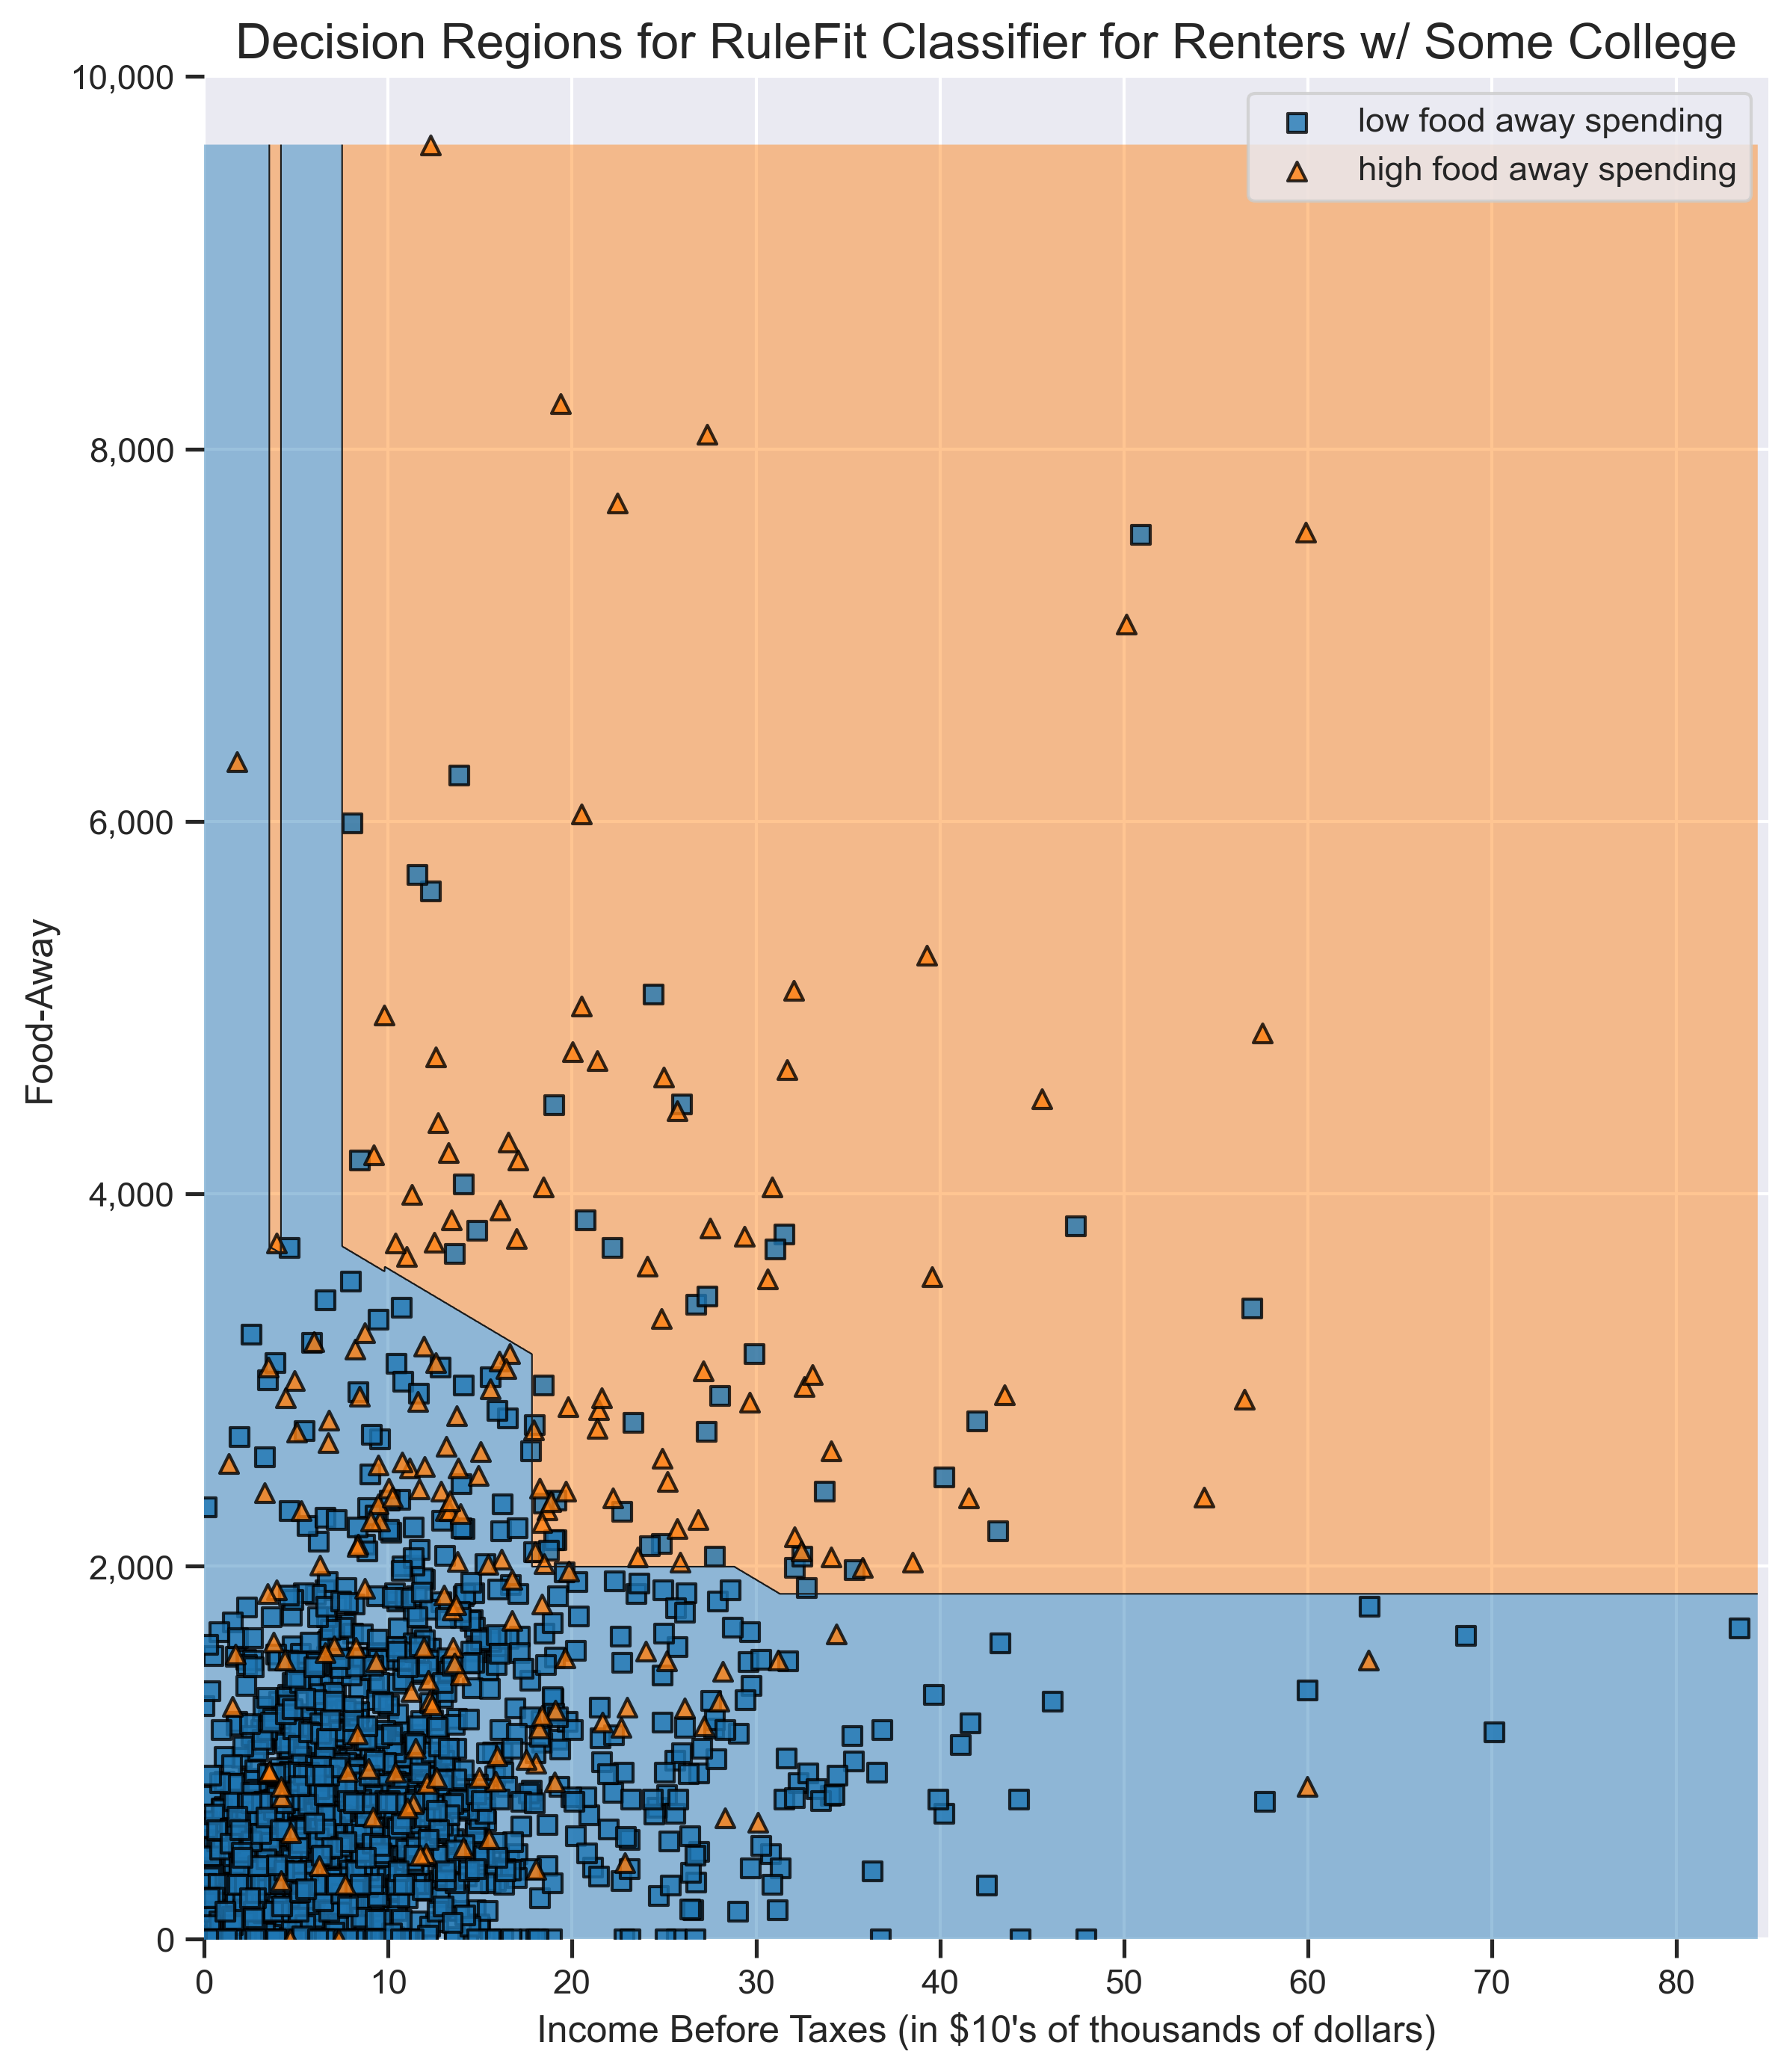

In [48]:
feature_index = [1,10]
filler_values = {0: 7, 2: 3, 3: 2, 4: 1, 5: 2, 6: 1, 7: 1, 8: 0, 9: 1, 11: 0, 12: 0, 13: 0,\
                 14: 0, 15: 1, 16: 0, 17: 0, 18: 1}
filler_ranges = {i:X_test_std[i]*3 for i in range(19) if i not in feature_index}

plt.figure(figsize=(9, 11))
ax = plot_decision_regions(X_test.values, y_test.values[:,0], clf=mdl, legend=2,\
                    feature_index=feature_index, filler_feature_values=filler_values,\
                    filler_feature_ranges=filler_ranges)
ax.set_xlabel("Income Before Taxes (in $10's of thousands of dollars)")
ax.set_ylabel("Food-Away")
leg=plt.legend()
leg.get_texts()[0].set_text(class_l[0])
leg.get_texts()[1].set_text(class_l[1])
ax.set_xlim(0, 85)
ax.set_ylim(0, 10000)
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
plt.title('Decision Regions for RuleFit Classifier for Renters w/ Some College', fontsize=16)
plt.show()

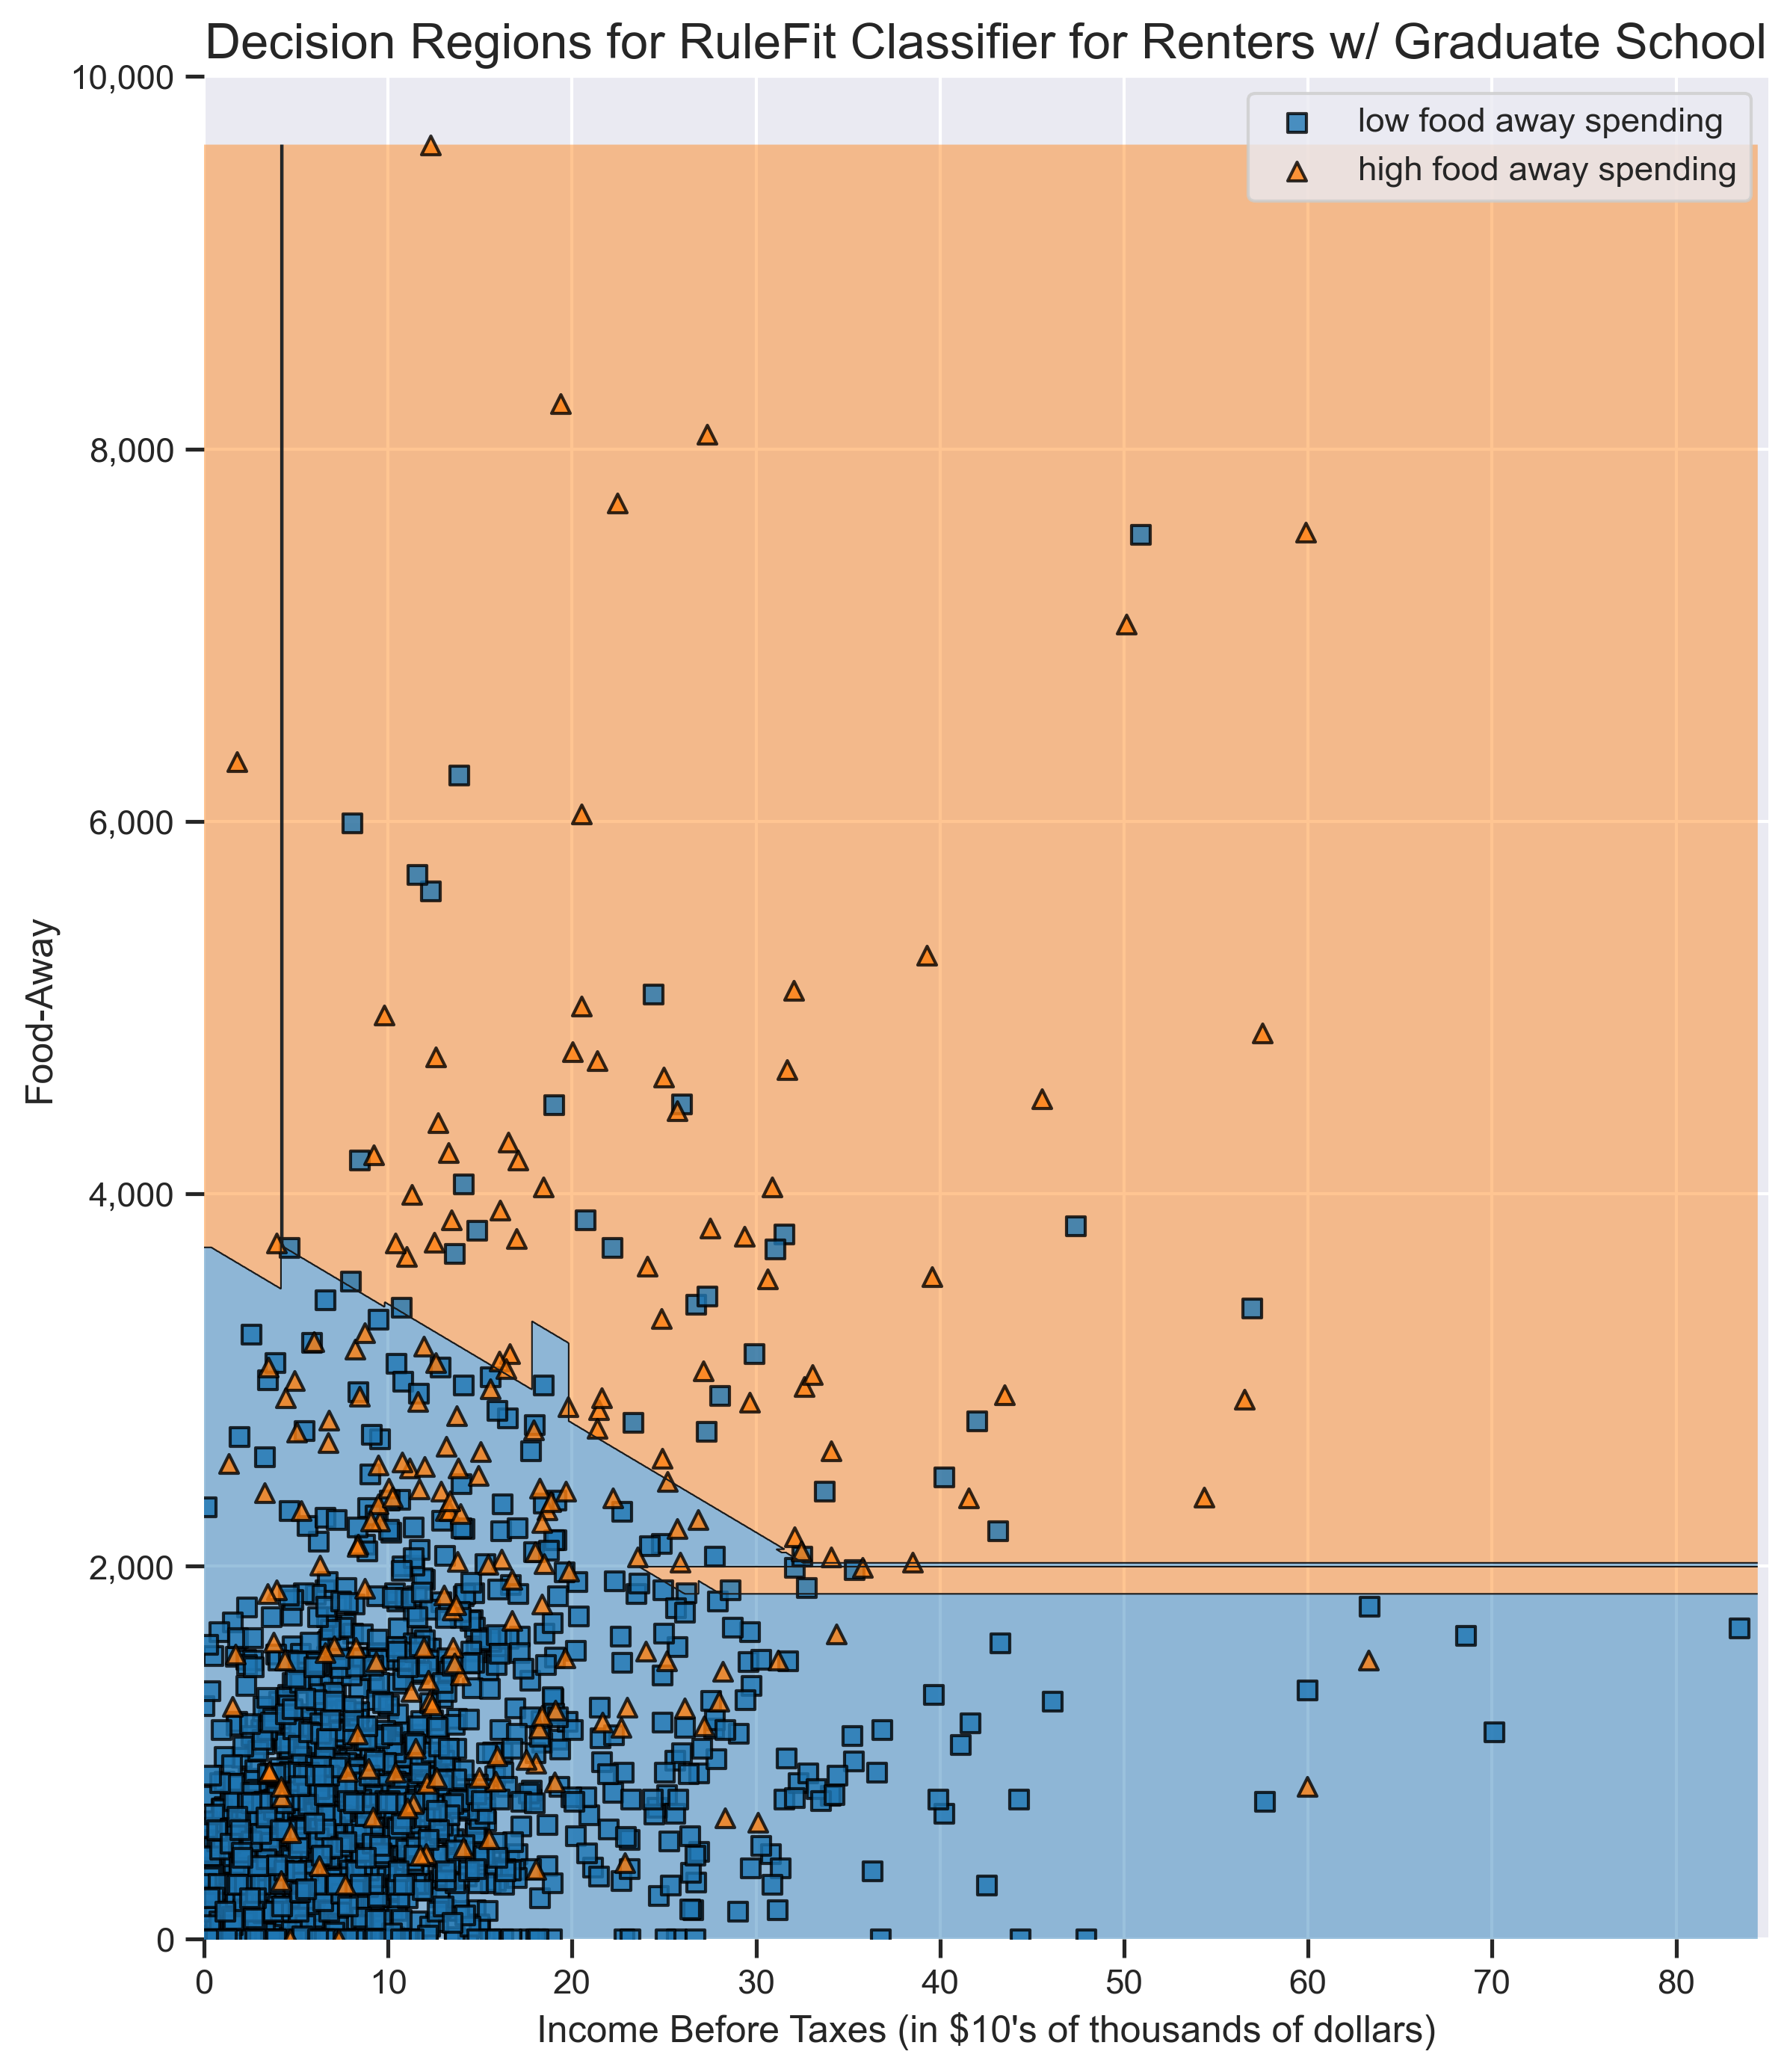

In [49]:
feature_index = [1,10]
filler_values = {0: 7, 2: 3, 3: 2, 4: 1, 5: 2, 6: 1, 7: 1, 8: 0, 9: 0, 11: 0, 12: 1, 13: 0,\
                 14: 0, 15: 0, 16: 0, 17: 0, 18: 1}
filler_ranges = {i:X_test_std[i]*3 for i in range(19) if i not in feature_index}

plt.figure(figsize=(9, 11))
ax = plot_decision_regions(X_test.values, y_test.values[:,0], clf=mdl, legend=2,\
                    feature_index=feature_index, filler_feature_values=filler_values,\
                    filler_feature_ranges=filler_ranges)
ax.set_xlabel("Income Before Taxes (in $10's of thousands of dollars)")
ax.set_ylabel("Food-Away")
leg=plt.legend()
leg.get_texts()[0].set_text(class_l[0])
leg.get_texts()[1].set_text(class_l[1])
ax.set_xlim(0, 85)
ax.set_ylim(0, 10000)
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
plt.title('Decision Regions for RuleFit Classifier for Renters w/ Graduate School', fontsize=16)
plt.show()